# **Loan Approval Prediction**

Tools and technologies  Python, SQLLite3, Numpy, Pandas, scikit-learn, DagsHub, MLFlow, Docker, AWS, FastAPI,Streamlit

**Import required modules**

In [ ]:
import os
import csv
import sqlite3
import dagshub
import mlflow
import joblib
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow.sklearn
import seaborn as sns
import ydata_profiling
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

**Install required modules**

In [ ]:
#%pip install -q dagshub mlflow
#%pip install ydata-profiling

**Load Data CSV Data File**

In [ ]:
with open('loan_data.csv', mode='r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)

    # Read the header (first row) and display it
    header = next(csv_reader)
    print(header)

['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']


**Cleaning dataset**

In [ ]:
input_file = 'loan_data.csv'
output_file = 'cleaned_data.csv'

# List of columns that we want to keep for loan approval classification
columns_to_keep = [
    'person_age', 'person_gender', 'person_education', 'person_income',
    'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'credit_score', 'previous_loan_defaults_on_file', 'loan_status'
]

# Open the input file to read
with open(input_file, mode='r') as infile:
    csv_reader = csv.DictReader(infile)  # Read the CSV as a dictionary for better column access
    fieldnames = csv_reader.fieldnames  # Get column names from the CSV

    # Create a list of rows that will be written to the output file
    cleaned_rows = []

    for row in csv_reader:
        # Check if the row has missing values (skip rows with missing values)
        if all(row[col] != '' and row[col] is not None for col in columns_to_keep):
            # Keep only the relevant columns
            cleaned_row = {col: row[col] for col in columns_to_keep}
            cleaned_rows.append(cleaned_row)

# Remove duplicate rows based on all columns
unique_rows = []
seen_rows = set()

for row in cleaned_rows:
    # Convert row to a tuple of values (since tuples are hashable) for checking duplicates
    row_tuple = tuple(row[col] for col in columns_to_keep)
    if row_tuple not in seen_rows:
        unique_rows.append(row)
        seen_rows.add(row_tuple)

# Write the cleaned and unique data to a new CSV file
with open(output_file, mode='w', newline='') as outfile:
    csv_writer = csv.DictWriter(outfile, fieldnames=columns_to_keep)
    csv_writer.writeheader()  # Write the header
    csv_writer.writerows(unique_rows)  # Write the unique rows

print(f"Data cleaned, duplicates removed, and saved to {output_file}")


Data cleaned, duplicates removed, and saved to cleaned_data.csv


Normalization of Dataset

In [ ]:
# Connect to SQLite database (it will create a new file if it doesn't exist)
conn = sqlite3.connect('loan_approval.db')
cursor = conn.cursor()

# Create tables in 3NF
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Persons (
        person_id INTEGER PRIMARY KEY AUTOINCREMENT,
        person_age INTEGER,
        person_gender TEXT,
        person_education TEXT,
        person_income REAL,
        person_emp_exp REAL,
        person_home_ownership TEXT,
        cb_person_cred_hist_length REAL
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Loans (
        loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
        person_id INTEGER,
        loan_amnt REAL,
        loan_intent TEXT,
        loan_int_rate REAL,
        loan_percent_income REAL,
        FOREIGN KEY (person_id) REFERENCES Persons (person_id)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Loan_Status (
        loan_id INTEGER,
        loan_status TEXT,
        PRIMARY KEY (loan_id),
        FOREIGN KEY (loan_id) REFERENCES Loans (loan_id)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Loan_History (
        person_id INTEGER,
        previous_loan_defaults_on_file INTEGER,
        FOREIGN KEY (person_id) REFERENCES Persons (person_id)
    )
''')

# Now, we will read the cleaned CSV and insert the data into the normalized tables

# Replace 'cleaned_data.csv' with the path to your cleaned data file
input_file = 'cleaned_data.csv'

with open(input_file, mode='r') as infile:
    csv_reader = csv.DictReader(infile)

    for row in csv_reader:
        # Insert into Persons table
        cursor.execute('''
            INSERT INTO Persons (person_age, person_gender, person_education, person_income,
                                 person_emp_exp, person_home_ownership, cb_person_cred_hist_length)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (row['person_age'], row['person_gender'], row['person_education'], row['person_income'],
              row['person_emp_exp'], row['person_home_ownership'], row['cb_person_cred_hist_length']))

        # Get the person_id of the inserted person
        person_id = cursor.lastrowid

        # Insert into Loans table
        cursor.execute('''
            INSERT INTO Loans (person_id, loan_amnt, loan_intent, loan_int_rate, loan_percent_income)
            VALUES (?, ?, ?, ?, ?)
        ''', (person_id, row['loan_amnt'], row['loan_intent'], row['loan_int_rate'], row['loan_percent_income']))

        # Get the loan_id of the inserted loan
        loan_id = cursor.lastrowid

        # Insert into Loan_Status table
        cursor.execute('''
            INSERT INTO Loan_Status (loan_id, loan_status)
            VALUES (?, ?)
        ''', (loan_id, row['loan_status']))

        # Insert into Loan_History table
        cursor.execute('''
            INSERT INTO Loan_History (person_id, previous_loan_defaults_on_file)
            VALUES (?, ?)
        ''', (person_id, row['previous_loan_defaults_on_file']))

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Data has been inserted into the normalized database (3NF).")


Data has been inserted into the normalized database (3NF).


**Inserting Data wtih joins**

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('loan_approval.db')

# SQL JOIN statement to fetch data from the tables
query = '''
    SELECT p.person_id, p.person_age, p.person_gender, p.person_education,
           p.person_income, p.person_emp_exp, p.person_home_ownership,
           p.cb_person_cred_hist_length, l.loan_amnt, l.loan_intent,
           l.loan_int_rate, l.loan_percent_income, ls.loan_status,
           lh.previous_loan_defaults_on_file
    FROM Persons p
    JOIN Loans l ON p.person_id = l.person_id
    JOIN Loan_Status ls ON l.loan_id = ls.loan_id
    JOIN Loan_History lh ON p.person_id = lh.person_id
'''

# Execute the query and load the result into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection to the database
conn.close()

# Display the DataFrame
print(df.head())


   person_id  person_age person_gender person_education  person_income  \
0          1          22        female           Master        71948.0   
1          2          21        female      High School        12282.0   
2          3          25        female      High School        12438.0   
3          4          23        female         Bachelor        79753.0   
4          5          24          male           Master        66135.0   

   person_emp_exp person_home_ownership  cb_person_cred_hist_length  \
0             0.0                  RENT                         3.0   
1             0.0                   OWN                         2.0   
2             3.0              MORTGAGE                         3.0   
3             0.0                  RENT                         2.0   
4             1.0                  RENT                         4.0   

   loan_amnt loan_intent  loan_int_rate  loan_percent_income loan_status  \
0    35000.0    PERSONAL          16.02             

**Ploting the distribution of the target variable**

Loan Status Distribution:
 loan_status
0    140000
1     40000
Name: count, dtype: int64


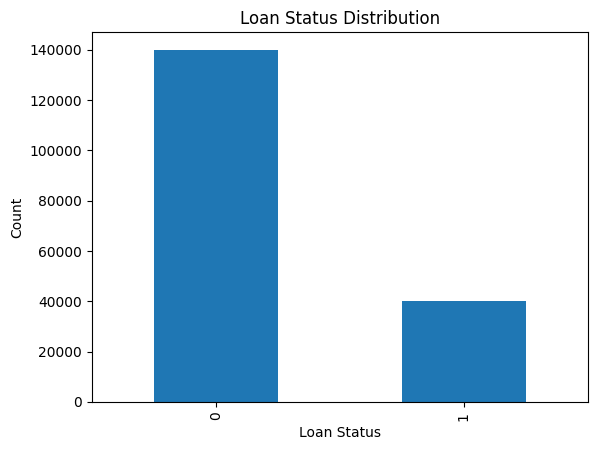

In [ ]:
#Explore the distribution of the target variable (loan_status)
print("Loan Status Distribution:\n", df['loan_status'].value_counts())

#visualize the distribution
df['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()



**Spliting data into train and test**

In [ ]:
#  Perform the train/test split with stratification
X = df.drop('loan_status', axis=1)  # Features
y = df['loan_status']  # Target

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution in train/test sets
print("Train Loan Status Distribution:\n", y_train.value_counts())
print("Test Loan Status Distribution:\n", y_test.value_counts())

# Optionally: Verify the split
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Train Loan Status Distribution:
 loan_status
0    112000
1     32000
Name: count, dtype: int64
Test Loan Status Distribution:
 loan_status
0    28000
1     8000
Name: count, dtype: int64
Training set size: 144000
Testing set size: 36000


**yDatta Profiling**

In [ ]:
#Generate the profile report for EDA
profile = ProfileReport(df, title="Loan Dataset EDA Report", explorative=True)

# Save the report as an HTML file
profile.to_file("loan_dataset_eda_report.html")

#Display the report in a Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Plotting Matrix Correlation**

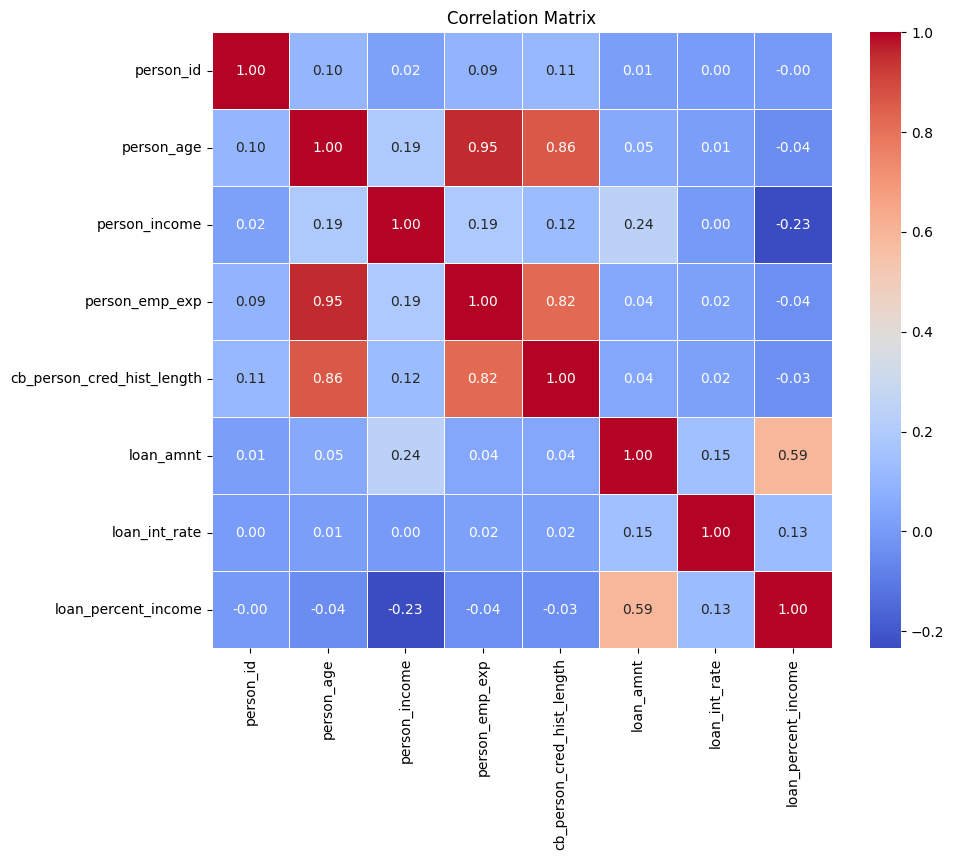

In [ ]:
#Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns
correlation_matrix = df[numeric_columns].corr()

#Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Initialize Dagshub**

In [ ]:
dagshub.init(repo_owner='Pgadgil12', repo_name='Loan_Approval_Classification', mlflow=True)

Accessing as Pgadgil12

Initialized MLflow to track repo "Pgadgil12/Loan_Approval_Classification"

Repository Pgadgil12/Loan_Approval_Classification initialized!

**Integrate MLflow**

In [ ]:
mlflow.set_tracking_uri("https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow")

**Encoding data**

In [ ]:
# Load your dataset
df = pd.read_csv("loan_data.csv")

# Identify categorical columns
categorical_features = df.select_dtypes(include=["object", "category"]).columns
target_column = "loan_status"

# Step 1: Apply Label Encoding to the target variable
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

# Step 2: Apply One-Hot Encoding to other categorical features
categorical_features = [col for col in categorical_features if col != target_column]

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Display the resulting DataFrame
print("Encoded DataFrame:")
print(df_encoded.head())


Encoded DataFrame:
   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0        22.0        71948.0               0    35000.0          16.02   
1        21.0        12282.0               0     1000.0          11.14   
2        25.0        12438.0               3     5500.0          12.87   
3        23.0        79753.0               0    35000.0          15.23   
4        24.0        66135.0               1    35000.0          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  \
0                 0.49                         3.0           561            1   
1                 0.08                         2.0           504            0   
2                 0.44                         3.0           635            1   
3                 0.44                         2.0           675            1   
4                 0.53                         4.0           586            1   

   person_gender_male  ...  person_education_Mast

In [ ]:
#Drop redundant columns
columns_to_drop = ["person_gender_male",  # Drop one binary gender column
                   "person_home_ownership_OTHER",  # Drop redundant home ownership category if needed
                   "loan_intent_VENTURE"]  # Example: drop least frequent loan intent (based on domain knowledge)
df_encoded = df_encoded.drop(columns=columns_to_drop)

#Drop low-variance columns
low_variance_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() <= 1]
df_encoded = df_encoded.drop(columns=low_variance_cols)

#Print remaining columns for confirmation
print("Remaining Columns After Cleanup:")
print(df_encoded.columns)

Remaining Columns After Cleanup:
Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'loan_status', 'person_education_Bachelor',
       'person_education_Doctorate', 'person_education_High School',
       'person_education_Master', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'previous_loan_defaults_on_file_Yes'],
      dtype='object')


In [ ]:
# Print the column names used during training
print(model.feature_importances_.shape)
print(list(df.columns))  #list of training features

# Print the columns you're using for prediction
print(df_encoded.columns)


(19,)
['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']
Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'loan_status', 'person_education_Bachelor',
       'person_education_Doctorate', 'person_education_High School',
       'person_education_Master', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'previous_loan_defaults_on_file_Yes'],
      dtype='object')


**Experiment 1**

In [ ]:
mlflow.set_experiment("Experiment 1 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/9bbf756819e1410783e0651949eb9365', creation_time=1734588791856, experiment_id='0', last_update_time=1734588791856, lifecycle_stage='active', name='Experiment 1 - Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Separate features and target
X = df_encoded.drop(columns=["loan_status"])
y = df_encoded["loan_status"]

# Define preprocessing steps
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("minmax", MinMaxScaler()),
            ("log", FunctionTransformer(np.log1p))  # Apply log transformation
        ]), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter tuning grid
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"]
}

# Set up cross-validation
cv = 10




In [ ]:
# Start an MLFlow experiment
with mlflow.start_run(run_name="Logistic_Regression_Experiment") as run:

    # Perform cross-validation using StratifiedKFold with 10 folds
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

    # Log the parameters and metrics
    mlflow.log_param("cv_folds", 10)
    # Log the mean and std F1 score from cross-validation
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)

    # Evaluate on the training and test set using the full training data
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate F1 score for train and test set
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Log the F1 scores
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("test_f1", test_f1)

    # Log confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Log the model as an artifact
    mlflow.sklearn.log_model(pipeline, "model")

    # Print results
    print("CV Mean F1:", mean_f1)
    print("CV Std F1:", std_f1)
    print("Train F1:", train_f1)
    print("Test F1:", test_f1)
    print("Confusion Matrix:", (tp, tn, fp, fn))

2024/12/20 03:22:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CV Mean F1: 0.5071959642846019
CV Std F1: 0.011536823050610384
Train F1: 0.507545231887493
Test F1: 0.5023969319271332
Confusion Matrix: (786, 6657, 343, 1214)
🏃 View run Logistic_Regression_Experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/0/runs/a7a4d752eb954e13a0d49bcdc0a68e53
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/0


**Experiment 2**

In [ ]:
mlflow.set_experiment("Experiment 2 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/87164e537d0b4e24986380762ac832d1', creation_time=1734589462434, experiment_id='1', last_update_time=1734589462434, lifecycle_stage='active', name='Experiment 2 - Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Separate features and target
X = df_encoded.drop("loan_status", axis=1)  # 'loan_status' is the target column
y = df_encoded["loan_status"]

# Encode Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define models for the pipeline
classifiers = {
    "LogisticRegression": LogisticRegression(solver="liblinear"),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Cross-validation & Metrics Logging
def log_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {"F1-Score": f1, "TP": tp, "TN": tn, "FP": fp, "FN": fn}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Start MLFlow experiment
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name}_Experiment") as run:

        # Create a complete pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', clf)
        ])

        # Perform cross-validation using StratifiedKFold with 10 folds
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Create StratifiedKFold object

        # Use cross_validate instead of cross_val_score to get more metrics
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring='f1')
        f1_scores = scores['test_score']  # Extract the 'test_score' which contains the f1 scores

        # Log parameters and metrics
        mlflow.log_param("cv_folds", 10)
        # Log the mean and std F1 score from cross-validation
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        mlflow.log_metric(f"{clf_name}_cv_mean_f1", mean_f1)
        mlflow.log_metric(f"{clf_name}_cv_std_f1", std_f1)

        # Fit the final pipeline (after cross-validation)
        pipeline.fit(X_train, y_train)

        # Get the predictions
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Calculate F1 score for train and test set
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Log the F1 scores
        mlflow.log_metric(f"{clf_name}_train_f1", train_f1)
        mlflow.log_metric(f"{clf_name}_test_f1", test_f1)

        # Log confusion matrix metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        mlflow.log_metric(f"{clf_name}_true_positive", tp)
        mlflow.log_metric(f"{clf_name}_true_negative", tn)
        mlflow.log_metric(f"{clf_name}_false_positive", fp)
        mlflow.log_metric(f"{clf_name}_false_negative", fn)

        # Log the model as an artifact
        mlflow.sklearn.log_model(pipeline, f"{clf_name}_model")

        # Print results
        print(f"{clf_name} - CV Mean F1:", mean_f1)
        print(f"{clf_name} - CV Std F1:", std_f1)
        print(f"{clf_name} - Train F1:", train_f1)
        print(f"{clf_name} - Test F1:", test_f1)
        print(f"{clf_name} - Confusion Matrix:", (tp, tn, fp, fn))

2024/12/20 03:22:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression - CV Mean F1: 0.5043756310167526
LogisticRegression - CV Std F1: 0.0030804646696121424
LogisticRegression - Train F1: 0.507545231887493
LogisticRegression - Test F1: 0.5023969319271332
LogisticRegression - Confusion Matrix: (786, 6657, 343, 1214)
🏃 View run LogisticRegression_Experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1/runs/c37c1c32dd4f4db19d5a739d88c449c7
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1


2024/12/20 03:23:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier - CV Mean F1: 0.4578439785082922
RidgeClassifier - CV Std F1: 0.005130437477636282
RidgeClassifier - Train F1: 0.46034054932831353
RidgeClassifier - Test F1: 0.4529085872576177
RidgeClassifier - Confusion Matrix: (654, 6766, 234, 1346)
🏃 View run RidgeClassifier_Experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1/runs/6e4c0f69063946e090bfa1960104e56d
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1


2024/12/20 03:23:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier - CV Mean F1: 0.6624196703213577
RandomForestClassifier - CV Std F1: 0.002469136794198432
RandomForestClassifier - Train F1: 1.0
RandomForestClassifier - Test F1: 0.685682326621924
RandomForestClassifier - Confusion Matrix: (1226, 6650, 350, 774)
🏃 View run RandomForestClassifier_Experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1/runs/e239820581e04fc5a01ba6f491572485
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:23:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/20 03:23:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

XGBClassifier - CV Mean F1: 0.6680539396040842
XGBClassifier - CV Std F1: 0.0016431001191273974
XGBClassifier - Train F1: 0.7872325883398263
XGBClassifier - Test F1: 0.6872946330777655
XGBClassifier - Confusion Matrix: (1255, 6603, 397, 745)
🏃 View run XGBClassifier_Experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1/runs/4d926a9b1006459eb41b8bcac8ea6a70
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/1


**Experminet 3**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 3 -Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/47ed66df0b1c49c9be7a7e3357f81ee6', creation_time=1734648472058, experiment_id='3', last_update_time=1734648472058, lifecycle_stage='active', name='Experiment 3 -Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Separate features and target
X = df_encoded.drop("loan_status", axis=1)  # 'loan_status' is the target column
y = df_encoded["loan_status"]

# Encode Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Feature Engineering: Create new features
def feature_engineering(df):
    df = df.copy()
    if "loan_amnt" in df.columns and "annual_inc" in df.columns:
        df["debt_to_income_ratio"] = df["loan_amnt"] / (df["annual_inc"] + 1e-9)
    if "int_rate" in df.columns and "installment" in df.columns:
        df["interest_installment_ratio"] = df["int_rate"] / (df["installment"] + 1e-9)
    return df

# ColumnTransformer for preprocessing
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Define models for the pipeline
models = {
    "LogisticRegression": LogisticRegression(solver="liblinear"),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
}

# Cross-validation & Metrics Logging
def log_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {"F1-Score": f1, "TP": tp, "TN": tn, "FP": fp, "FN": fn}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [ ]:
# Loop through models and log metrics to MLFlow
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name}_with_Feature_Engineering"):
        mlflow.log_param("Model", model_name)

        # Create pipeline for each model
        pipeline = Pipeline([
            ("feature_engineering", FunctionTransformer(feature_engineering, validate=False)),
            ("preprocessor", preprocessor),
            ("classifier", model),
        ])

        # Cross-Validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="f1_macro")
        mean_score = scores.mean()
        std_score = scores.std()

        # Train the model on the full training data
        pipeline.fit(X_train, y_train)
        metrics = log_metrics(pipeline, X_test, y_test)

        # Log Metrics to MLFlow
        mlflow.log_metric("Mean_CV_F1", mean_score)
        mlflow.log_metric("STD_CV_F1", std_score)
        for key, value in metrics.items():
            mlflow.log_metric(key, value)

        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline_with_Feature_Engineering")

        print(f"Model: {model_name}")
        print(f"Mean CV F1-Score: {mean_score:.4f}, STD: {std_score:.4f}")

2024/12/20 03:24:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
Mean CV F1-Score: 0.7062, STD: 0.0022
🏃 View run LogisticRegression_with_Feature_Engineering at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3/runs/09a59fbc5b5948a3b63b0f49fddce6f1
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3


2024/12/20 03:24:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7896, STD: 0.0024
🏃 View run RandomForestClassifier_with_Feature_Engineering at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3/runs/a8eabc04e1654a9996baa41d573bebae
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/20 03:24:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

Model: XGBClassifier
Mean CV F1-Score: 0.7921, STD: 0.0014
🏃 View run XGBClassifier_with_Feature_Engineering at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3/runs/a32f5a2804904ce8a616fa18e0ead2a3
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/3


**Experiment 4**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 4 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/90e464496ea547d28834bc78810e186f', creation_time=1734650009253, experiment_id='4', last_update_time=1734650009253, lifecycle_stage='active', name='Experiment 4 - Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Define the DataFrame and target variable
X = df_encoded.drop("loan_status", axis=1)  # Features
y = df_encoded["loan_status"]  # Target

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

# List of feature selection methods
feature_selection_methods = ["Correlation_Threshold", "Feature_Importance", "Variance_Threshold"]

In [ ]:
with mlflow.start_run(run_name="Feature_Selection") as run:
    # 1. Correlation Threshold
    correlation_threshold = 0.85
    corr_matrix = X_train.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop_corr = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

    X_train_corr = X_train.drop(columns=to_drop_corr, axis=1)
    X_test_corr = X_test.drop(columns=to_drop_corr, axis=1)

    mlflow.log_param("correlation_threshold", correlation_threshold)
    mlflow.log_metric("features_removed_corr", len(to_drop_corr))
    mlflow.log_metric("features_remaining_corr", X_train_corr.shape[1])

    # 2. Variance Threshold
    variance_threshold = 0.01
    var_thresh = VarianceThreshold(threshold=variance_threshold)
    X_train_var = var_thresh.fit_transform(X_train_corr)
    X_test_var = var_thresh.transform(X_test_corr)

    selected_features_var = X_train_corr.columns[var_thresh.get_support(indices=True)]

    mlflow.log_param("variance_threshold", variance_threshold)
    mlflow.log_metric("features_removed_variance", len(X_train_corr.columns) - len(selected_features_var))
    mlflow.log_metric("features_remaining_variance", len(selected_features_var))

    # 3. Feature Importance
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_var, y_train)
    feature_importances = rf.feature_importances_

    # Select top features based on importance (threshold = median importance)
    importance_threshold = np.median(feature_importances)
    important_indices = np.where(feature_importances >= importance_threshold)[0]
    X_train_final = X_train_var[:, important_indices]
    X_test_final = X_test_var[:, important_indices]

    mlflow.log_param("importance_threshold", importance_threshold)
    mlflow.log_metric("features_removed_importance", len(selected_features_var) - len(important_indices))
    mlflow.log_metric("features_remaining_importance", len(important_indices))

    # Log selected features
    selected_features_final = selected_features_var[important_indices]
    mlflow.log_text("\n".join(selected_features_final), "selected_features.txt")

    # Iterate through each feature selection method and model
    for method in feature_selection_methods:
        for model_name, model in models.items():
            # Start a nested run for each model and feature selection combination
            with mlflow.start_run(run_name=f"{model_name}_{method}", nested=True):
                # Log the feature selection method and model name
                mlflow.log_param("Feature Selection Method", method)
                mlflow.log_param("Model", model_name)

            # Perform cross-validation
            if method == "Correlation_Threshold":
                X_train_method = X_train_corr
                X_test_method = X_test_corr
            elif method == "Variance_Threshold":
                X_train_method = X_train_var
                X_test_method = X_test_var
            elif method == "Feature_Importance":
                X_train_method = X_train_final
                X_test_method = X_test_final

            # Cross-validation with F1-score
            cv_scores = cross_val_score(model, X_train_method, y_train, cv=5, scoring='f1')
            mean_f1 = np.mean(cv_scores)
            std_f1 = np.std(cv_scores)

            # Log mean F1 and standard deviation
            mlflow.log_metric(f"{model_name}_mean_cv_f1", mean_f1)
            mlflow.log_metric(f"{model_name}_std_cv_f1", std_f1)

            print(f"Feature Selection Method: {method}, Model: {model_name}")
            print(f"Mean CV F1-Score: {mean_f1:.4f}, STD: {std_f1:.4f}")

            # Log the model to MLFlow
            mlflow.sklearn.log_model(model, f"{model_name}_{method}_model")
    print("Feature Selection Complete")


🏃 View run Logistic Regression_Correlation_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/38bfa068325f45f7a2ffca0ae85a93be
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature Selection Method: Correlation_Threshold, Model: Logistic Regression
Mean CV F1-Score: 0.4141, STD: 0.1098


2024/12/20 03:25:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Classifier_Correlation_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/23c304101e7947188132f116782147c7
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Correlation_Threshold, Model: Ridge Classifier
Mean CV F1-Score: 0.7412, STD: 0.0101


2024/12/20 03:25:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest_Correlation_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/84f2496e2a43427399a30174ff6668c7
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Correlation_Threshold, Model: Random Forest
Mean CV F1-Score: 0.8247, STD: 0.0054


2024/12/20 03:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Correlation_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/8ea46afcb6df4bc4828f3705c305cc12
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Correlation_Threshold, Model: XGBoost
Mean CV F1-Score: 0.8385, STD: 0.0041


2024/12/20 03:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression_Feature_Importance at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/f12f3bc4e5634758b1a0ecbf22bd1ed1
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Feature_Importance, Model: Logistic Regression
Mean CV F1-Score: 0.4104, STD: 0.1080


2024/12/20 03:26:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Classifier_Feature_Importance at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/b66f368d4e864b4ab621a46ba738b810
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Feature_Importance, Model: Ridge Classifier
Mean CV F1-Score: 0.6756, STD: 0.0080


2024/12/20 03:26:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest_Feature_Importance at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/f782b9962a7948cca72f28d6696424c5
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Feature_Importance, Model: Random Forest
Mean CV F1-Score: 0.8132, STD: 0.0068


2024/12/20 03:27:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Feature_Importance at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/87362fe8403a44d3890abc93b5e3dc2a
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Feature_Importance, Model: XGBoost
Mean CV F1-Score: 0.8227, STD: 0.0053


2024/12/20 03:27:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression_Variance_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/11cba7294f3c476886b80965508f6490
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Variance_Threshold, Model: Logistic Regression
Mean CV F1-Score: 0.4144, STD: 0.1100


2024/12/20 03:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Classifier_Variance_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/7efd2bccbd2447cd97579e972a878674
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Variance_Threshold, Model: Ridge Classifier
Mean CV F1-Score: 0.6819, STD: 0.0097


2024/12/20 03:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/20 03:27:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/90e464496ea547d28834bc78810e186f/1ba8fd88a4ac475f8510622a0e95d968/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


🏃 View run Random Forest_Variance_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/c08e5cb2fb0f45ee9b5147771fd49b87
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Variance_Threshold, Model: Random Forest
Mean CV F1-Score: 0.8211, STD: 0.0069


2024/12/20 03:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/20 03:28:14 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/90e464496ea547d28834bc78810e186f/1ba8fd88a4ac475f8510622a0e95d968/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


🏃 View run XGBoost_Variance_Threshold at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/849df47dbf9c459a9c7b7d9a0c3d6261
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4
Feature Selection Method: Variance_Threshold, Model: XGBoost
Mean CV F1-Score: 0.8354, STD: 0.0024


2024/12/20 03:28:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/20 03:28:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/90e464496ea547d28834bc78810e186f/1ba8fd88a4ac475f8510622a0e95d968/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


Feature Selection Complete
🏃 View run Feature_Selection at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4/runs/1ba8fd88a4ac475f8510622a0e95d968
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/4


**Experminet 5**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 5 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/505ca834937f4263a296edc1d541c6e9', creation_time=1734652321748, experiment_id='6', last_update_time=1734652321748, lifecycle_stage='active', name='Experiment 5 - Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Define the DataFrame and target variable
X = df_encoded.drop("loan_status", axis=1)  # Features
y = df_encoded["loan_status"]  # Target

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Feature Selection Method: PCA, Model: RandomForestClassifier
Mean CV F1-Score: 0.3675, STD: 0.0061


2024/12/20 03:29:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


PCA and RandomForest model training complete
🏃 View run PCA at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/6/runs/9771451073264f4bb401a404219bdea3
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/6


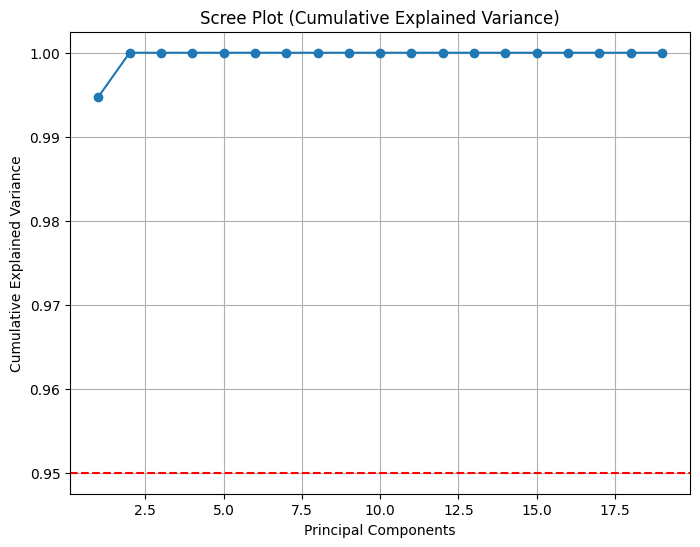

In [ ]:
with mlflow.start_run(run_name="PCA") as run:
    # 1. Apply PCA
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # 2. Create scree plot
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
    plt.title("Scree Plot (Cumulative Explained Variance)")
    plt.xlabel("Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.savefig("scree_plot.png")

    # Log scree plot to MLFlow
    mlflow.log_artifact("scree_plot.png")

    # 3. Determine the number of components to retain based on 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Add 1 because index starts at 0
    mlflow.log_param("n_components", n_components)

    # 4. Apply PCA with the selected number of components
    pca = PCA(n_components=n_components)
    X_train_pca_selected = pca.fit_transform(X_train)
    X_test_pca_selected = pca.transform(X_test)

    # Log the number of components selected
    mlflow.log_param("n_components_selected", n_components)

    # 5. RandomForestClassifier Model
    rf = RandomForestClassifier(random_state=42)

    # Cross-validation with F1-score
    cv_scores = cross_val_score(rf, X_train_pca_selected, y_train, cv=5, scoring='f1')
    mean_f1 = np.mean(cv_scores)
    std_f1 = np.std(cv_scores)

    # Log mean F1 and standard deviation
    mlflow.log_metric("RandomForest_mean_cv_f1", mean_f1)
    mlflow.log_metric("RandomForest_std_cv_f1", std_f1)

    print(f"Feature Selection Method: PCA, Model: RandomForestClassifier")
    print(f"Mean CV F1-Score: {mean_f1:.4f}, STD: {std_f1:.4f}")

    # Log the RandomForest model to MLFlow
    mlflow.sklearn.log_model(rf, "RandomForest_PCA_model")

    print("PCA and RandomForest model training complete")

**Expermient 6**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 6 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/a6be1f8e52a942f7adc74fdb5137a65d', creation_time=1734654903795, experiment_id='7', last_update_time=1734654903795, lifecycle_stage='active', name='Experiment 6 - Loan_Approval_Classification_Experiment', tags={}>

In [ ]:
# Define the DataFrame and target variable
X = df_encoded.drop("loan_status", axis=1)  # Features
y = df_encoded["loan_status"]  # Target

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Start the experiment run
with mlflow.start_run(run_name="Custom_Experiment_RandomForest") as run:
    # Initialize RandomForestClassifier model
    rf_model = RandomForestClassifier(random_state=42)

    # Train the model
    rf_model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test_scaled)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Log model metrics and details
    mlflow.log_param("model_name", "RandomForestClassifier")
    mlflow.log_metric("RandomForest_accuracy", accuracy)
    mlflow.log_param("RandomForest_confusion_matrix", str(conf_matrix))
    mlflow.log_param("RandomForest_classification_report", class_report)

    # Log the model
    mlflow.sklearn.log_model(rf_model, "RandomForest_model")

    # Optional: Log confusion matrix and classification report as text files
    with open("RandomForest_confusion_matrix.txt", "w") as f:
        f.write(str(conf_matrix))
    with open("RandomForest_classification_report.txt", "w") as f:
        f.write(class_report)

    # Log text files in MLFlow
    mlflow.log_artifact("RandomForest_confusion_matrix.txt")
    mlflow.log_artifact("RandomForest_classification_report.txt")

    # Print results
    print(f"Model: RandomForestClassifier, Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")

    print("Custom RandomForest Experiment Execution Complete")


2024/12/20 03:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier, Accuracy: 0.9289
Confusion Matrix:
[[6815  185]
 [ 455 1545]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7000
           1       0.89      0.77      0.83      2000

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000

Custom RandomForest Experiment Execution Complete
🏃 View run Custom_Experiment_RandomForest at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/7/runs/052e040f8087490c8239d0fe41c7832e
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/7


**Expermient 7**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 7 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/1629275de4dc4033ac39460e435f03e3', creation_time=1734655129258, experiment_id='8', last_update_time=1734655129258, lifecycle_stage='active', name='Experiment 7 - Loan_Approval_Classification_Experiment', tags={}>

2024/12/20 03:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Enhanced_RandomForest at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/8/runs/da606084e7a74278bdac540af66d07c9
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/8


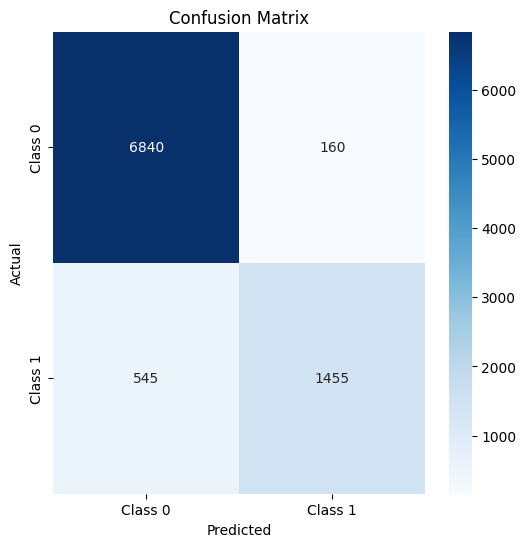

In [ ]:
# Define dataset
X = df_encoded.drop("loan_status", axis=1)  # Features
y = df_encoded["loan_status"]  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with mlflow.start_run(run_name="Enhanced_RandomForest") as run:
    # Define the Random Forest Classifier model with basic parameters
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Train the model
    rf.fit(X_train_scaled, y_train)

    # Make predictions using the trained model
    y_pred = rf.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Log the metrics
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1)

    # Log the feature importances as a string to avoid size limits
    feature_importances = rf.feature_importances_
    # Log feature importances as an artifact to avoid size limits with mlflow.log_param
    feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
    feature_importances_df.to_csv('feature_importances.csv', index=False)
    mlflow.log_artifact('feature_importances.csv')

    # Log the trained model
    mlflow.sklearn.log_model(rf, "random_forest_model")

    # Plot and log confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the confusion matrix plot to a temporary file
    import tempfile
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
        plt.savefig(temp_file.name)
        mlflow

**F1-score Plots**

In [ ]:
# MLFlow Experiment
mlflow.set_experiment("Experiment 8 - Loan_Approval_Classification_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/19939720ea8d4be4bbfda4a4fd726398', creation_time=1734656606142, experiment_id='10', last_update_time=1734656606142, lifecycle_stage='active', name='Experiment 8 - Loan_Approval_Classification_Experiment', tags={}>

2024/12/20 03:32:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression, F1-score: 0.4813
🏃 View run Experiment #X: Model Comparison with F1-Score_Correlation_Threshold_LogisticRegression at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/6f07fec2113940dbaca2ff36c3591a40
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:33:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier, F1-score: 0.7530
🏃 View run Experiment #X: Model Comparison with F1-Score_Correlation_Threshold_RidgeClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/fcb59c2bd87c46f6b5a1f1df546cd32a
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:33:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier, F1-score: 0.8291
🏃 View run Experiment #X: Model Comparison with F1-Score_Correlation_Threshold_RandomForestClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/118d62c2cb834ec99bc5b581cf1b7b0d
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression, F1-score: 0.4813
🏃 View run Experiment #X: Model Comparison with F1-Score_Feature_Importance_LogisticRegression at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/91d71f6178044778bcb65a9ad6282c42
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier, F1-score: 0.7530
🏃 View run Experiment #X: Model Comparison with F1-Score_Feature_Importance_RidgeClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/83431e97af0b430baa7ca46243176b11
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:33:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier, F1-score: 0.8291
🏃 View run Experiment #X: Model Comparison with F1-Score_Feature_Importance_RandomForestClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/34bc5f7c6503477798a938804a1e2469
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression, F1-score: 0.4813
🏃 View run Experiment #X: Model Comparison with F1-Score_Variance_Threshold_LogisticRegression at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/1c373c9187534e1a8035525b02718faf
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier, F1-score: 0.7530
🏃 View run Experiment #X: Model Comparison with F1-Score_Variance_Threshold_RidgeClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/c535b84f536d4867aa27ecb8cad35d53
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


2024/12/20 03:34:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier, F1-score: 0.8291
🏃 View run Experiment #X: Model Comparison with F1-Score_Variance_Threshold_RandomForestClassifier at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/42e0bd757df34602bee67ccdb15e44f7
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10


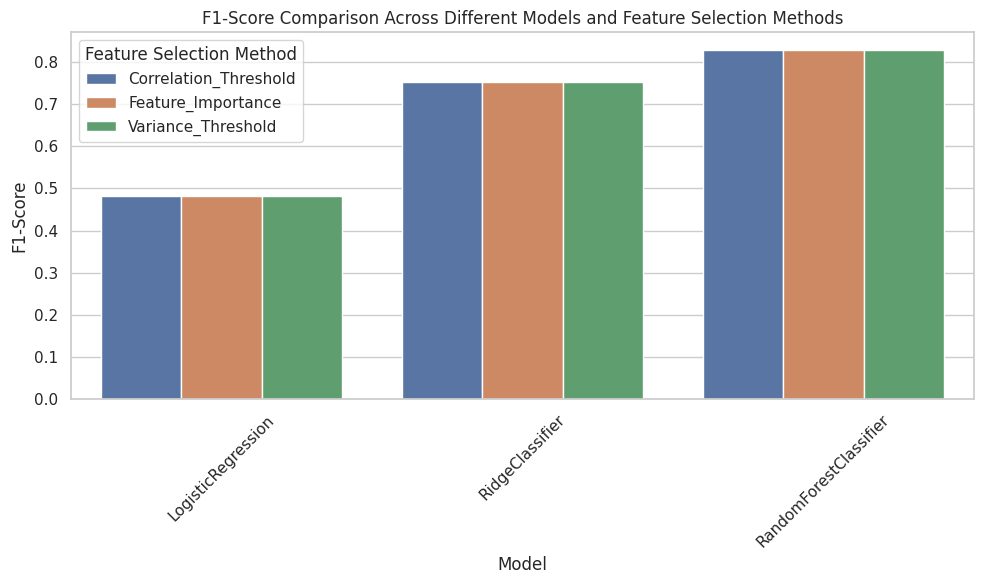

In [ ]:
# Define a function to log F1-score and other metrics
def log_and_plot_f1(model, X_train, y_train, X_test, y_test, model_name, experiment_name, method_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)

    # Log model and metrics to MLFlow
    with mlflow.start_run(run_name=f"{experiment_name}_{method_name}_{model_name}") as run:
        mlflow.log_param("model", model_name)
        mlflow.log_param("feature_selection_method", method_name)
        mlflow.log_metric("f1_score", f1)

        # Log model
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        # Print the run details
        print(f"Model: {model_name}, F1-score: {f1:.4f}")

    return f1

# Define your experiment and method names
experiment_name = "Experiment #X: Model Comparison with F1-Score"
methods = ['Correlation_Threshold', 'Feature_Importance', 'Variance_Threshold']

# Example setup for your experiment, assuming X_train, y_train, X_test, y_test are ready
models = [
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('RidgeClassifier', RidgeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
]

# Store F1-scores for each model and method
f1_scores = []

# Loop through methods and models and log F1-scores
for method in methods:
    for model_name, model in models:
        f1 = log_and_plot_f1(model, X_train, y_train, X_test, y_test, model_name, experiment_name, method)
        f1_scores.append({'method': method, 'model': model_name, 'f1_score': f1})

# Convert the F1-scores to a DataFrame
import pandas as pd
f1_scores_df = pd.DataFrame(f1_scores)

# Plot F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(data=f1_scores_df, x='model', y='f1_score', hue='method')

plt.title('F1-Score Comparison Across Different Models and Feature Selection Methods')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Feature Selection Method")
plt.show()


**Storing final model using joblib.**

In [ ]:
#RandomForestClassifier has been trained
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Save the final model locally using joblib
joblib_file = "final_rf_model.joblib"
joblib.dump(final_model, joblib_file)
print(f"Final model saved as {joblib_file}")

# Optionally, log the final model to MLFlow
with mlflow.start_run(run_name="Final_Model_RF"):
    mlflow.log_param("model", "RandomForestClassifier")
    mlflow.log_param("description", "Final Random Forest model after all experiments.")

    # Log the model using MLFlow
    mlflow.sklearn.log_model(final_model, "final_model_random_forest")
    print("Final model logged to MLFlow.")


Final model saved as final_rf_model.joblib


2024/12/20 03:36:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final model logged to MLFlow.
🏃 View run Final_Model_RF at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10/runs/d44149a0d9264784a69bb01b6ba4e111
🧪 View experiment at: https://dagshub.com/Pgadgil12/Loan_Approval_Classification.mlflow/#/experiments/10
